In [2]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm
import os
import warnings
from typing import List, Tuple, Dict, Union
from pathlib import Path

In [3]:
warnings.filterwarnings("ignore")

# Empty cache before every run so that RAM doesn't blow up
torch.cuda.empty_cache()

In [4]:
# Path to Parquet files
DATA_DIR = Path("BIG_DATA/2008/")
print(sorted(os.listdir(DATA_DIR)))

['200801.gzip', '200802.gzip', '200803.gzip', '200804.gzip', '200805.gzip', '200806.gzip', '200807.gzip', '200808.gzip', '200809.gzip', '200810.gzip']


In [11]:
def collect_data(directory_path: Union[str, Path]) -> pd.DataFrame:
    '''
    Read data from a directory of Parquet files into a pandas DataFrame.

    Parameters
    ----------
    directory_path : str
        Path to directory of Parquet files.

    Returns
    -------
    DataFrame
        Consolidated information from Parquet files.
    '''
    files = sorted(os.listdir(directory_path))
    data = pd.read_parquet(directory_path / files[0])
    data.drop(['LQFRAC'], axis = 1, inplace = True)
    data.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
    for i in range(1,len(os.listdir(directory_path))):
        data_intermediate = pd.read_parquet(directory_path / files[i])
        data_intermediate.rename(columns={'Unnamed: 0': 'time'}, inplace=True)
        data_intermediate.drop(['LQFRAC'], axis = 1, inplace = True)
        data = pd.concat([data, data_intermediate], axis = 0)

    return data 

In [12]:
data: pd.DataFrame = collect_data(DATA_DIR)

In [13]:
print(data.shape)
print(f"The number of features available to us: {data.shape[1]}")
print(data.columns)

(7319943, 56)
The number of features available to us: 56
Index(['time', 'comid', 'catid', 'du', 'pair_id', 'U2D', 'V2D', 'LWDOWN',
       'RAINRATE', 'T2D', 'Q2D', 'PSFC', 'SWDOWN', 'streamflow',
       'elevation_mean', 'slope_mean', 'impervious_mean', 'aspect_c_mean',
       'twi_dist_4', 'X', 'Y', 'gw_Coeff', 'gw_Zmax', 'gw_Expon',
       'bexp_soil_layers_stag=1', 'bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 'ISLTYP',
       'IVGTYP', 'dksat_soil_layers_stag=1', 'dksat_soil_layers_stag=2',
       'dksat_soil_layers_stag=3', 'dksat_soil_layers_stag=4',
       'psisat_soil_layers_stag=1', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 'cwpvt',
       'mfsno', 'mp', 'quartz_soil_layers_stag=1', 'quartz_soil_layers_stag=2',
       'quartz_soil_layers_stag=3', 'quartz_soil_layers_stag=4', 'refkdt',
       'slope', 'smcmax_soil_layers_stag=1', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_

In [14]:
# Drop redundant columns
data.drop(['bexp_soil_layers_stag=2',
       'bexp_soil_layers_stag=3', 'bexp_soil_layers_stag=4', 
       'dksat_soil_layers_stag=2', 'dksat_soil_layers_stag=3', 
       'dksat_soil_layers_stag=4', 'psisat_soil_layers_stag=2',
       'psisat_soil_layers_stag=3', 'psisat_soil_layers_stag=4', 
       'quartz_soil_layers_stag=2', 'quartz_soil_layers_stag=3', 
       'quartz_soil_layers_stag=4', 'smcmax_soil_layers_stag=2',
       'smcmax_soil_layers_stag=3', 'smcmax_soil_layers_stag=4',
       'smcwlt_soil_layers_stag=2', 'smcwlt_soil_layers_stag=3', 
       'smcwlt_soil_layers_stag=4',  'bexp_soil_layers_stag=1', 'cwpvt', 'mp', 
       'quartz_soil_layers_stag=1', 'vcmx25', 'aspect_c_mean', 'gw_Coeff', 
       'gw_Zmax', 'gw_Expon', 'psisat_soil_layers_stag=1', 
       'smcmax_soil_layers_stag=1', 'smcwlt_soil_layers_stag=1', 'refkdt'], 
       axis = 1, inplace = True)
print(f"After dropping a few columns, the number of new features available to "\
      "us is: {len(data.columns)}")

After dropping a few columns, the number of new features available to us is: {len(data.columns)}


In [15]:
def load_data_in_dictionary(
        data: pd.DataFrame
        ) -> Tuple[Dict[int, pd.DataFrame], int, pd.DataFrame]:
    '''
    Load data into a dictionary. Each index of dictionary has a pair of 
    watersheds, upper and lower, and their features are merged in the for loop 
    below. Watersheds with invalid data from the input DataFrame are not 
    included in the dictionary.

    Parameters
    ----------
    data : pd.DataFrame
        Consolidated model data.

    Returns
    -------
    dict
        The keys contain the basin pair indices. The values are a DataFrame
        that contain the information from the input DataFrame that correspond
        specifically to a basin pair.

    int
        The number of basin pairs in the dictionary.

    pd.DataFrame
        One example DataFrame for a basin pair. This is used later to define
        columns for our final dataset.
    '''
    num_networks = 0
    network_dict = {}

    for i in range(int((data['pair_id']).max())+1):
        downstream = data[(data['pair_id']== i) & (data['du'] == 'd')]
        upstream = data[(data['pair_id']== i) & (data['du'] == 'u')]

        if downstream.empty or downstream.isnull().values.any():
            print(i, " DS is empty")
            continue
        if upstream.empty or upstream.isnull().values.any():
            print(i, " US is empty or the upstream flow is constant")
            continue

        network = downstream.merge(upstream, on="time")
        network_dict[num_networks] = network
        num_networks += 1

    real_id = 0
    for key in network_dict.keys():
        if key != real_id:
            network_dict[real_id] = network_dict.pop(key)
        real_id += 1

    return network_dict, num_networks, network

In [16]:
network_dict, num_networks, network = load_data_in_dictionary(
    data)

print(f"The number of networks we have:\t{len(network_dict)}")
print(f"The number of data points in each network:\t{network_dict[0].shape[0]}")
print(f"The number of features in each network:\t{network_dict[0].shape[1]}")

33  DS is empty
36  US is empty or the upstream flow is constant
65  US is empty or the upstream flow is constant
169  DS is empty
170  US is empty or the upstream flow is constant
195  US is empty or the upstream flow is constant
199  DS is empty
270  US is empty or the upstream flow is constant
281  DS is empty
291  DS is empty
303  DS is empty
331  DS is empty
390  US is empty or the upstream flow is constant
425  US is empty or the upstream flow is constant
457  US is empty or the upstream flow is constant
The number of networks we have:	485
The number of data points in each network:	7320
The number of features in each network:	49


In [17]:
# Drop redundant information
network.drop(['time', 'comid_x', 'catid_x', 'du_x', 'pair_id_x', 'twi_dist_4_x', 
              'comid_y', 'catid_y', 'du_y', 'pair_id_y', 'twi_dist_4_y', "X_x", 
              "Y_x", "X_y", "Y_y"], axis = 1, inplace=True)

reduced_features = network.columns.to_list()

In [18]:
# Check for CUDA enabled devices
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA device:", torch.cuda.get_device_name(0))
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple M3/M2/M1 (Metal) device")
else:
    device = 'cpu'
    print("Using CPU")

# Define sequence length
seq_length = 550

Using CPU


In [19]:
# Calculate train-val-test split
n_networks = len(network_dict)
n_networks_split = {"train": (math.floor(n_networks * 0.7)), 
                    "val": math.floor(n_networks * 0.2), 
                    "test": math.floor(n_networks * 0.1)}

In [20]:
def split_parameters(
        n_networks: int, 
        n_networks_split: Dict[str, int] = n_networks_split
        ) -> List[List[List[int]]]:
    ''' 
    Create list of network indices for each split.

    Parameters
    ----------
    n_networks : int
        Number of networks in dictionary.
    n_networks_split : dict
        Number of networks in train/validation/test splits.

    Returns
    -------
    list
        A list where each element is a sub-list containing the indices of the 
        networks in each split. The first element is the indices of the training
        data, the second element is the indices of the validation data, and the 
        third element is the indices of the testing data.
    '''
    networks_for_training = list(range(0, n_networks_split['train'] + 1))
    networks_for_val = list(range(n_networks_split['train'] + 1, 
                                 n_networks_split['train'] + n_networks_split[
                                     'val'] + 1))

    if (n_networks_split['test'] > 0):
        networks_for_test = list(range(n_networks - n_networks_split['test'], 
                                       n_networks))
    else:
        print("Since the dataset is small and no basins are available for "\
              "testing. We give a random bucket to test.")
        random_bucket = np.random.randint(0, n_networks)
        networks_for_test = [random_bucket]
    
    # organize the split parameters into separate lists for each set
    train_split_parameters = [networks_for_training]
    val_split_parameters = [networks_for_val]
    test_split_parameters = [networks_for_test]

    return [train_split_parameters, val_split_parameters, test_split_parameters]

In [21]:
[[networks_for_training], 
 [networks_for_val], 
 [networks_for_test]] = split_parameters(n_networks)
print(f"The networks for training is {networks_for_training}")
print(f"The networks for validation is {networks_for_val}")
print(f"The networks for testing is {networks_for_test}")

The networks for training is [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

In [22]:
def correlation_with_lstm_output(
        correlation_inputs: List[str],
        correlation_outputs: List[str],
        networks_for_training: List[int],
        network_dict: Dict[int, pd.DataFrame] = network_dict
    ) -> None:
    '''
    Generate a correlation matrix given model inputs. This function is 
    currently not used in our workflow. 

    Parameters
    ----------
    correlation_inputs : list
        List of model inputs.
    correlation_outputs : list
        List of model outputs.
    networks_for_training : list
        List of indices of networks in training set
    network_dict : dict
        The keys contain the basin pair indices. The values are a DataFrame
        that contain the information from the input DataFrame that correspond
        specifically to a basin pair.
    '''
    correlation_data = correlation_inputs + correlation_outputs
    frames = [network_dict[ibuc].loc[:, correlation_data] 
              for ibuc in networks_for_training]
    df_in = pd.concat(frames)
    correlation_matrix = np.corrcoef(df_in)

    for i in range(len(correlation_outputs)):
        print(f"Correlation with {correlation_outputs[i]}")
        for j in range(len(correlation_data)):
            print(f"{correlation_data[j]}: "/
                  f"{correlation_matrix[i+len(correlation_inputs)][j]}")

In [23]:
lstm_outputs = ['streamflow_y'] # what we're trying to predict using LSTM
n_output = len(lstm_outputs)

In [24]:
lstm_inputs = network.drop(["streamflow_y"], axis = 1).columns.to_list()
n_input = len(lstm_inputs)
print(f"The number of features for LSTM model:\t{n_input}")
print(lstm_inputs)

The number of features for LSTM model:	33
['U2D_x', 'V2D_x', 'LWDOWN_x', 'RAINRATE_x', 'T2D_x', 'Q2D_x', 'PSFC_x', 'SWDOWN_x', 'streamflow_x', 'elevation_mean_x', 'slope_mean_x', 'impervious_mean_x', 'ISLTYP_x', 'IVGTYP_x', 'dksat_soil_layers_stag=1_x', 'mfsno_x', 'slope_x', 'U2D_y', 'V2D_y', 'LWDOWN_y', 'RAINRATE_y', 'T2D_y', 'Q2D_y', 'PSFC_y', 'SWDOWN_y', 'elevation_mean_y', 'slope_mean_y', 'impervious_mean_y', 'ISLTYP_y', 'IVGTYP_y', 'dksat_soil_layers_stag=1_y', 'mfsno_y', 'slope_y']


In [25]:
def viz_networks(
        ibuc: int, 
        network_dict: Dict[int, pd.DataFrame] = network_dict
        )-> None:
    '''  
    Visualize upstream flow over time in each basin network over time.

    Parameters
    ----------
    ibuc : int
        Index of network.
    network_dict : dict
        The keys contain the basin pair indices. The values are a DataFrame
        that contain the information from the input DataFrame that correspond
        specifically to a basin pair.
    '''
    fig, ax = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", 
          np.round(network_dict[ibuc].streamflow_x.mean(), 2))
    print("Streamflow (upstream) mean:", 
          np.round(network_dict[ibuc].streamflow_y.mean(),2))

    network_dict[ibuc].loc[:2000,['streamflow_y']].plot(ax=ax, legend=False)

    ax.set_title('Streamflow')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Streamflow')

    ax.legend(["Streamflow_y"])
    
    plt.show()
    plt.close()

def viz_networks2(
        ibuc: int, 
        network_dict: Dict[int, pd.DataFrame] = network_dict
        )-> None:
    '''  
    Visualize upstream and downstream flow and precipitation in each basin 
    network over time. This function is not currently used in our workflow.

    Parameters
    ----------
    ibuc : int
        Index of network.
    network_dict : dict
        The keys contain the basin pair indices. The values are a DataFrame
        that contain the information from the input DataFrame that correspond
        specifically to a basin pair.
    '''
    fig, ax1 = plt.subplots()
    print('Network:', ibuc)
    print("Streamflow (downstream) mean:", 
          np.round(network_dict[ibuc].streamflow_x.mean(), 2))
    print("Streamflow (upstream) mean:", 
          np.round(network_dict[ibuc].streamflow_y.mean(), 2))

    # Plot streamflow_y on the primary y-axis
    network_dict[ibuc].loc[:2000, ['streamflow_x']].plot(ax=ax1, 
                                                         color = 'blue', 
                                                         legend=False)
    network_dict[ibuc].loc[:2000, ['streamflow_y']].plot(ax=ax1, 
                                                         color = 'purple', 
                                                         legend=False)
    ax1.set_title('Streamflow and Precipitation')
    ax1.set_xlabel('Time (h)')
    ax1.set_ylabel('Streamflow')
    
    # Create a secondary y-axis and plot APCP_surface_x on it
    ax2 = ax1.twinx()
    network_dict[ibuc].loc[:2000, ['APCP_surface_x']].plot(ax=ax2, 
                                                           color='orange', 
                                                           legend=False)
    
    network_dict[ibuc].loc[:2000, ['APCP_surface_y']].plot(ax=ax2, 
                                                           color='red', 
                                                           legend=False)
    ax2.set_ylabel('APCP Surface')
    
    # Add legends for each axis
    ax1.legend(["Streamflow_y"], loc='upper left')
    ax2.legend(["APCP_surface_x"], loc='upper right')
    
    plt.show()
    plt.close()

Network: 0
Streamflow (downstream) mean: 0.02
Streamflow (upstream) mean: 0.0


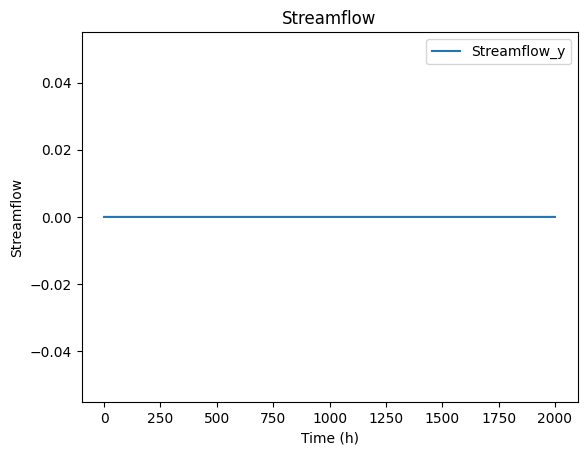

Network: 1
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.0


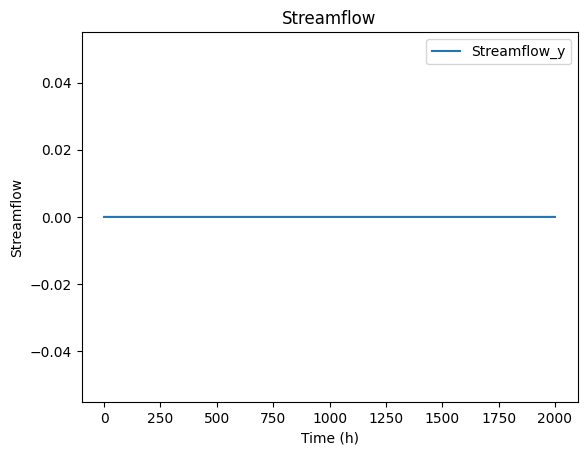

Network: 2
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.0


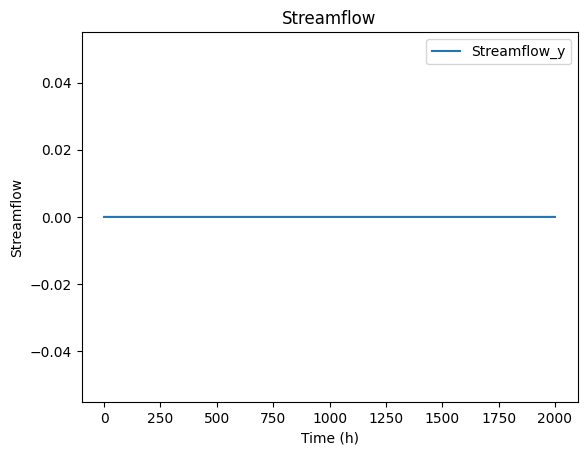

Network: 3
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.0


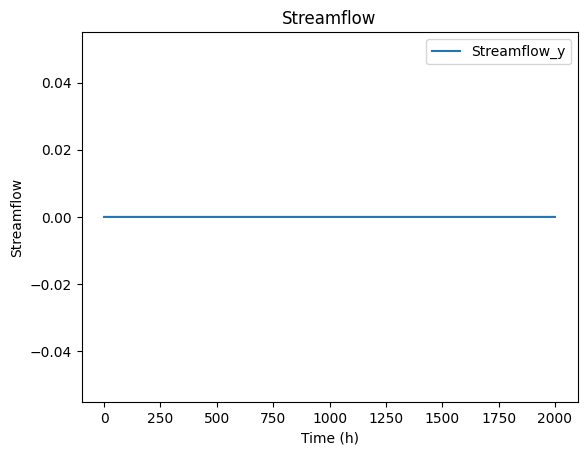

Network: 4
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.01


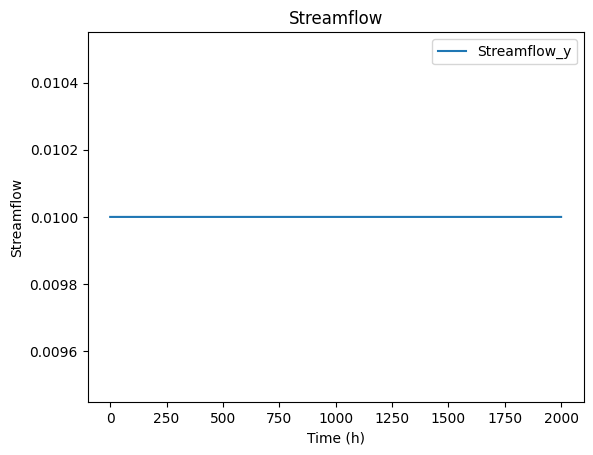

Network: 5
Streamflow (downstream) mean: 0.01
Streamflow (upstream) mean: 0.01


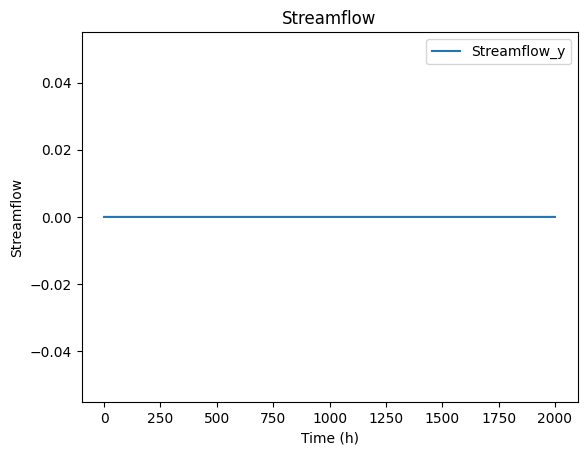

Network: 6
Streamflow (downstream) mean: 12.39
Streamflow (upstream) mean: 0.0


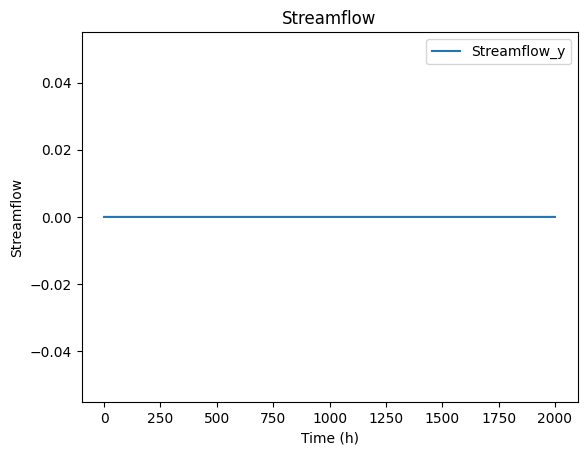

Network: 7
Streamflow (downstream) mean: 0.06
Streamflow (upstream) mean: 0.11


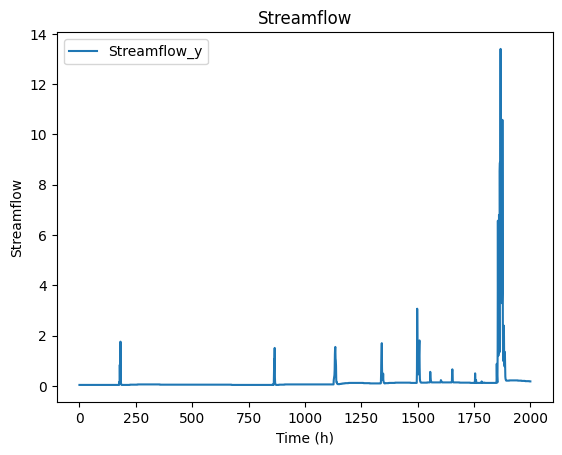

Network: 8
Streamflow (downstream) mean: 0.02
Streamflow (upstream) mean: 0.1


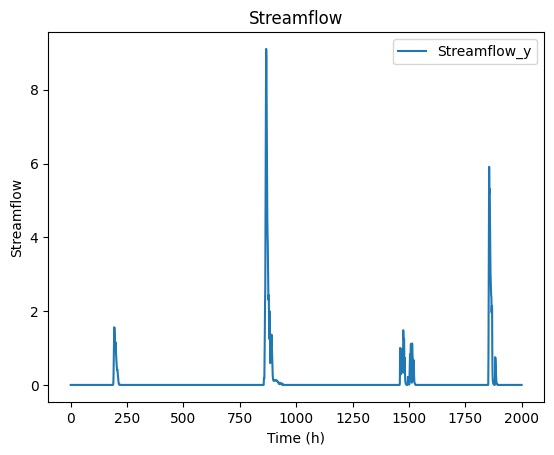

Network: 9
Streamflow (downstream) mean: 0.26
Streamflow (upstream) mean: 0.01


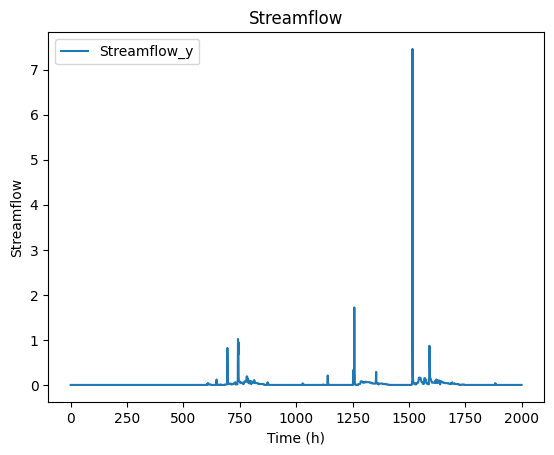

Network: 10
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.03


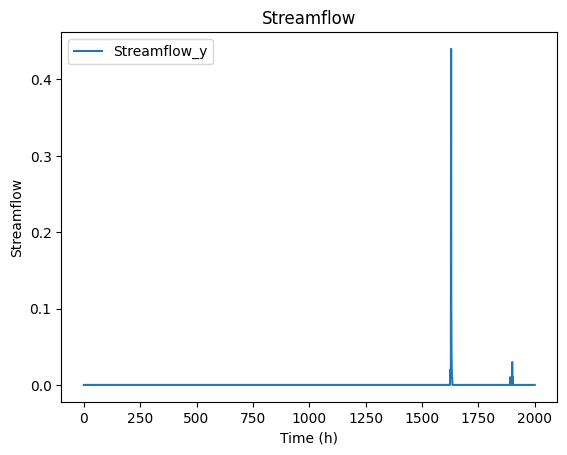

Network: 11
Streamflow (downstream) mean: 6.34
Streamflow (upstream) mean: 0.03


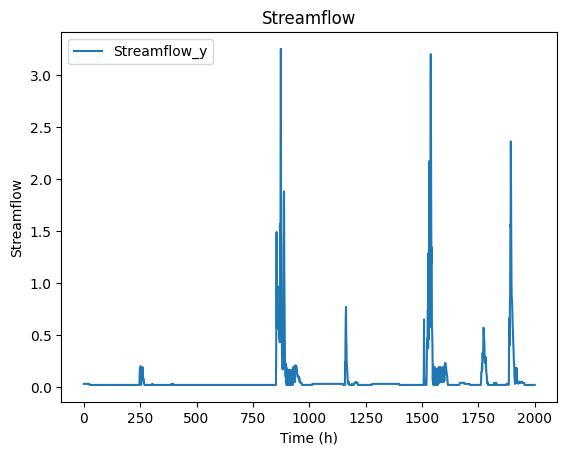

Network: 12
Streamflow (downstream) mean: 0.05
Streamflow (upstream) mean: 0.01


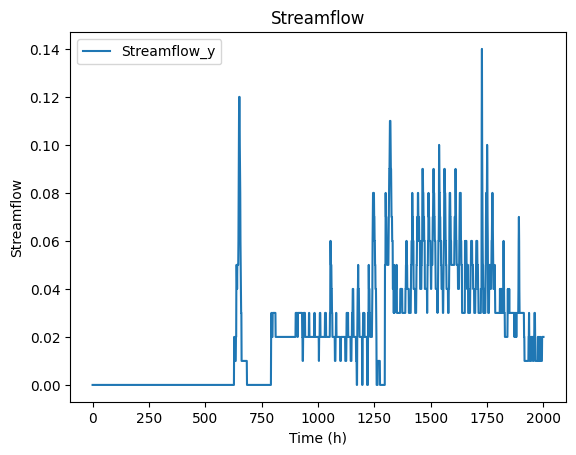

Network: 13
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.0


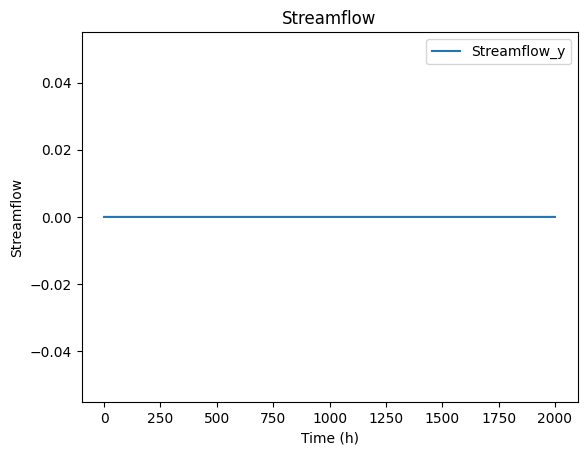

Network: 14
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.0


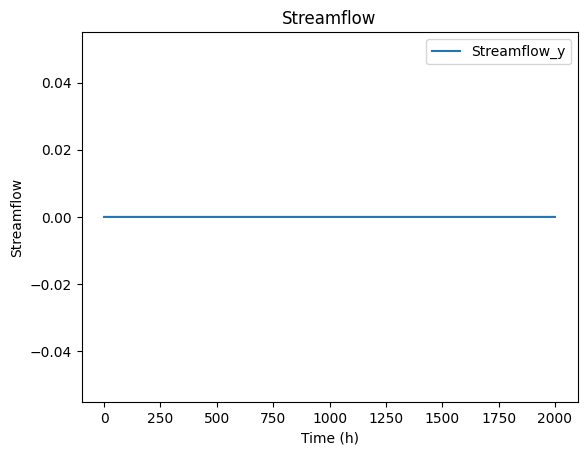

Network: 15
Streamflow (downstream) mean: 0.04
Streamflow (upstream) mean: 0.01


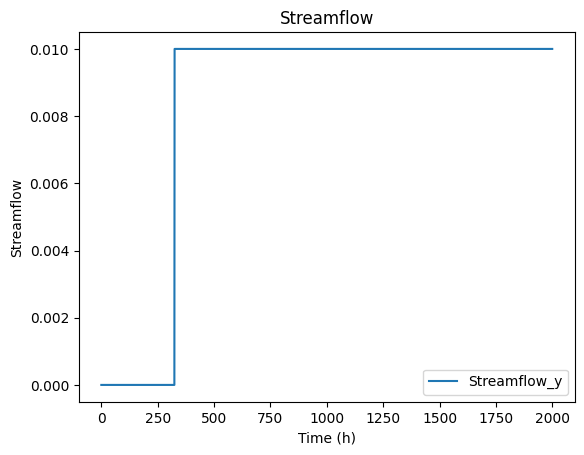

Network: 16
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.06


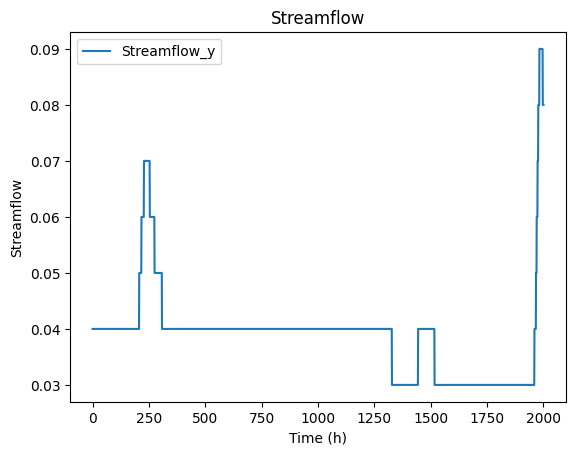

Network: 17
Streamflow (downstream) mean: 0.0
Streamflow (upstream) mean: 0.0


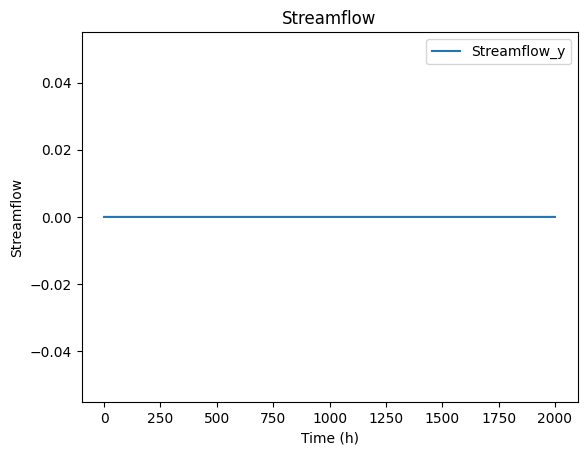

Network: 18
Streamflow (downstream) mean: 0.01
Streamflow (upstream) mean: 0.08


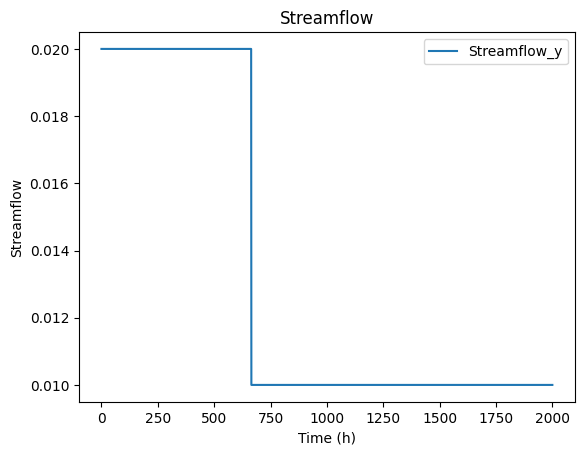

Network: 19
Streamflow (downstream) mean: 15.75
Streamflow (upstream) mean: 0.19


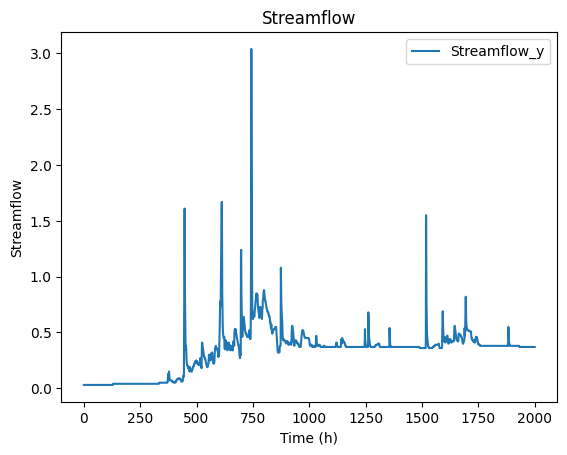

In [26]:
displayed = 0

for ibuc in networks_for_training:
    if displayed < 20: # ensures outputs don't get spammed with figures
        viz_networks(ibuc)
        displayed += 1
    else:
        break

In [27]:
class LSTM1(nn.Module):
    '''  
    A class representing an LSTM model.

    Attributes
    ----------
    input_size : int
        Number of input features.
    num_classes : int
        Number of output features.
    lstm1 : nn.LSTM
        LSTM layer.
    dropout1 : nn.Dropout
        Dropout layer.
    lstm2 : nn.LSTM
        LSTM layer.
    relu2 : nn.ReLU
        Rectified linear unit (ReLU) layer. Non-linear activation function.
    dropout2 : nn.Dropout
        Dropout layer.
    normalization1 : nn.BatchNorm1d
        Normalization layer.
    fc : nn.Sequential
        A sequential container.
    '''
    def __init__(self, input_size: int, num_classes: int) -> None:
        '''
        Construct an LSTM1 object.
        
        Parameters
        ----------
        input_size : int
            Number of input features.
        num_classes : int
            Number of output features.
        '''
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size

        self.lstm1 = nn.LSTM(input_size=input_size, 
                             hidden_size=128, 
                             batch_first=True)
        self.dropout1 = nn.Dropout(0.4)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.4)
        self.normalization1 = nn.BatchNorm1d(256)
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256, 128, bias=True),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64, bias = True),
            nn.ReLU(),
            nn.Linear(64, num_classes, bias=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''  
        Pass input data through the LSTM's layers.

        Parameters
        ----------
        x : torch.Tensor
            Input data.

        Returns
        -------
        torch.Tensor
            Model predictions based on input data.
        '''
        out, _= self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = out[:,-1, :]
        out = self.normalization1(out)

        prediction = self.fc(out)
        return prediction

In [28]:
model = LSTM1(input_size=n_input, num_classes=n_output).to(device)

In [29]:
def fit_scaler(
        network_dict: Dict[int, pd.DataFrame] = network_dict,
        networks_for_training: List[int] = networks_for_training,
        lstm_inputs: List[str] = lstm_inputs,
        lstm_outputs: List[str] = lstm_outputs
    ) -> Tuple[StandardScaler, StandardScaler]:
    '''  
    Create scalers fit on training data.

    Parameters
    ----------
    network_dict : dict
        The keys contain the basin pair indices. The values are a DataFrame
        that contain the information from the input DataFrame that correspond
        specifically to a basin pair.
    networks_for_training : list
        List of network indices in training set. 
    lstm_inputs : list
        List of features included in model inputs.
    lstm_outputs : list
        List of features included in model outputs.

    Returns
    -------
    StandardScaler
        Scaler for input variables.
    StandardScaler
        Scaler for output variables.
    '''
    frames = [network_dict[ibuc].loc[:, lstm_inputs] 
              for ibuc in networks_for_training]
    df_in = pd.concat(frames)   
    print(df_in.shape)
    scaler_in = StandardScaler()
    scaler_in.fit(df_in)

    frames = [network_dict[ibuc].loc[:, lstm_outputs] 
              for ibuc in networks_for_training]
    df_out = pd.concat(frames)    
    print(df_out.shape)
    scaler_out = StandardScaler()
    scaler_out.fit(df_out)
    return scaler_in, scaler_out

In [30]:
scaler_in, scaler_out = fit_scaler()

(2488760, 33)
(2488760, 1)


In [31]:
class EfficientDataset(torch.utils.data.Dataset):
    '''
    Dataset class that loads data only when necessary to preserve memory.

    Attributes
    ----------
    network_dict : dict
        The keys contain the basin pair indices. The values are a DataFrame
        that contain the information from the input DataFrame that correspond
        specifically to a basin pair.
    network_list : list
        List of network indices for a particular train/validation/test split.
    scaler_in : StandardScaler
        Scaler fit on input data.
    scaler_out : StandardScaler
        Scaler fit on output data.
    df : pd.DataFrame
        Concatenated data from network_dict
    '''
    def __init__(
            self,
            network_dict: Dict[int, pd.DataFrame] = network_dict,
            network_list: List[int] = networks_for_training,
            scaler_in: StandardScaler = scaler_in,
            scaler_out: StandardScaler = scaler_out
        ) -> None:
        ''' 
        Construct an EfficientDataset class.

        Parameters
        ----------
        network_dict : dict
            The keys contain the basin pair indices. The values are a DataFrame
            that contain the information from the input DataFrame that 
            correspond specifically to a basin pair.
        network_list : list
            List of network indices for a particular train/validation/test 
            split.
        scaler_in : StandardScaler
            Scaler fit on input data.
        scaler_out : StandardScaler
            Scaler fit on output data.
        '''
        self.network_dict = network_dict
        self.network_list = network_list
        self.scaler_in = scaler_in
        self.scaler_out = scaler_out
        self.df = pd.concat([network_dict[key] for key in network_list],
                            ignore_index=True)

    def __len__(self) -> int:
        '''Return number of networks in network_list.'''
        return len(self.df) 
    
    def transform(self, object: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        '''  
        Transform untransformed data using scalers.

        Parameters
        ----------
        object : pd.DataFrame
            Untransformed information.

        Returns
        -------
        np.ndarray
            Transformed input data.
        np.ndarray
            Transformed output data.
        '''
        object_in = object.loc[:, lstm_inputs]
        object_out = object.loc[:, lstm_outputs]
        scaler_in_i = self.scaler_in.transform(object_in)
        scaler_out_i = self.scaler_out.transform(object_out)

        return scaler_in_i, scaler_out_i
    
    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        '''
        Transform and access one row (represents one timestep in one particular
        basin network) in df.

        Parameters
        ----------
        idx : int
            Index of row in df.

        Returns
        -------
        np.ndarray
            Transformed input data.
        np.ndarray
            Transformed output data.
        '''
        try:
            object = self.df.iloc[[idx]]
            scaler_in_i, scaler_out_i = self.transform(object)

            return scaler_in_i.astype(np.float32), scaler_out_i.astype(
                np.float32)
        except Exception as e:
            print(e)
            df = self.network_dict[0]
            print("number of time steps in one network")
            print(len(df))
            print("total number of iterations in dataset")
            print(self.__len__())
            print("number of networks in this list")
            print(len(self.network_list))
            print("index at which fn failed")
            print(idx)

In [32]:
train_data = EfficientDataset(network_dict, networks_for_training, scaler_in, 
                              scaler_out)
val_data = EfficientDataset(network_dict, networks_for_val, scaler_in, 
                            scaler_out)
test_data = EfficientDataset(network_dict, networks_for_test, scaler_in,
                             scaler_out)

In [33]:
batch_size = 1024 # Number of rows (timesteps) to load at a time
shuffle = False # Determines if batches get shuffed when they are loaded
num_workers = 15 # Number of workers used to load data

# Create DataLoaders to iterate through EfficientDatasets
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           shuffle=shuffle, 
                                           num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=batch_size, 
                                         shuffle=shuffle, 
                                         num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size=batch_size, 
                                          shuffle=shuffle, 
                                          num_workers=num_workers)

In [34]:
def inverse_scale(
        scaler: StandardScaler, 
        numpy_value: np.float32
) -> np.float32:
    '''
    Invert scaler transformation.
    
    Parameters
    ----------
    scaler : StandardScaler
        Scaler whose transformation is to be undone.
    numpy_value : np.float32
        Transformed value.

    Returns 
    -------
    np.float32
        Untransformed value.
    '''
    transformed_numpy_value = scaler.inverse_transform(numpy_value)
    return transformed_numpy_value

In [35]:
def calculate_NSE(
        observed_value: np.float32, 
        modeled_value: np.float32
    ) -> np.float32:
    '''  
    Calculate Nash-Sutcliffe Efficiency (NSE) of LSTM prediction.

    Parameters
    ----------
    observed_value : np.float32
        Observed value.
    modeled_value : np.float32
        Predicted value.

    Returns
    -------
    np.float32
        NSE value.
    '''
    mean_observed_value = np.mean(observed_value)
    numerator = np.sum(np.power((observed_value - modeled_value), 2))
    denominator = np.sum(np.power((observed_value - mean_observed_value), 2))
    
    return round((1 - (numerator/denominator)), 2) 

In [36]:
class EarlyStopper:
    '''  
    A class that monitors a model's performance on a validation set and stops
    the training process when the loss does not improve to avoid overfitting.

    Attributes
    ----------
    patience : int
        Number of evaluations with no improvement before training stops.
    min_delta : int
        Minimum change in the loss to qualify as an improvement, i.e. a change
        of less than min_delta will count as no improvement.
    counter : int
        Keeps count of number of evaluations with no improvement.
    min_validation_loss : float
        The loss value that future evaluations' losses need to be less than by
        min_delta to count as an improvement.
    '''
    def __init__(self, patience: int = 5, min_delta: int = 0) -> None:
        '''
        Construct EarlyStopper class.

        Parameters
        ----------
        patience : int
            Number of evaluations with no improvement before training stops.
        min_delta : int
            Minimum change in the loss to qualify as an improvement, i.e. a 
            change of less than min_delta will count as no improvement.  
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss: float) -> bool:
        '''  
        Determine if training should stop. Training stops when counter is equal
        to patience, i.e. the number of evaluations in a row where there was no
        improvement in loss is equal to the patience value.

        Parameters
        ----------
        validation_loss : float
            Most recent loss value.

        Returns
        -------
        bool
            Training continues if False. Training stops if True.
        '''
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class EarlyStopperNSE:
    '''  
    A class that monitors a model's performance on a validation set and stops
    the training process when the NSE does not improve to avoid overfitting.

    Attributes
    ----------
    patience : int
        Number of evaluations with no improvement before training stops.
    min_delta : int
        Minimum change in the NSE to qualify as an improvement, i.e. a change
        of less than min_delta will count as no improvement.
    counter : int
        Keeps count of number of evaluations with no improvement.
    max_NSE : float
        The NSE value that future evaluations' NSEs need to be greater than by
        min_delta to count as an improvement.
    '''
    def __init__(self, patience: int = 5, min_delta: int = 0) -> None:
        '''
        Construct EarlyStopperNSE class.

        Parameters
        ----------
        patience : int
            Number of evaluations with no improvement before training stops.
        min_delta : int
            Minimum change in the NSE to qualify as an improvement, i.e. a 
            change of less than min_delta will count as no improvement.  
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.max_NSE = -100000000
    
    def early_stop(self, NSE: float) -> bool:
        '''  
        Determine if training should stop. Training stops when counter is equal
        to patience, i.e. the number of evaluations in a row where there was no
        improvement in NSE is equal to the patience value.

        Parameters
        ----------
        NSE : float
            Most recent NSE value.

        Returns
        -------
        bool
            Training continues if False. Training stops if True.
        '''
        if (NSE >= self.max_NSE):
            self.max_NSE = NSE
            self.counter = 0
        elif NSE <= (self.max_NSE - self.min_delta):
            self.counter += 1
            if(self.counter) >= self.patience:
                return True
        return False

In [37]:
early_stopper = EarlyStopper(patience = 15, min_delta= 0.001)
early_stopper_NSE = EarlyStopperNSE(patience = 15, min_delta = 0.05)

In [38]:
def train_model(
        lstm: LSTM1, 
        train_loader: torch.utils.data.DataLoader
        ) -> Tuple[LSTM1, List, List, List, List]:
    '''
    Train LSTM1 model using mean squared error (MSE) as loss and AdamW as 
    optimizer.  

    Parameters
    ----------
    lstm : LSTM1
        An LSTM1 class.
    train_loader : torch.utils.data.DataLoader
        DataLoader generated for training data.

    Returns
    -------
    LSTM1
        Trained LSTM1 model.
    list
        List of training MSEs.
    list
        List of validation MSEs.
    list
        List of training NSEs.
    list
        List of validation MSEs.
    '''
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(lstm.parameters(), lr= 0.001, weight_decay = 0.09)
    # reduces learning rate when loss has stopped improving
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                           patience = 10, 
                                                           factor = 0.8)
    epochs = 2
    loss_history_train = []
    loss_history_val = []
    NSE_train = []
    NSE_val = []
    for epoch in range(epochs):
        lstm.train()
        NSE_batch_train = []
        NSE_batch_val = []
        with tqdm(train_loader, unit="batch") as tepoch:
            for data, targets in train_loader:
                tepoch.set_description(f"Epoch {epoch} Training")

                loss_history_train_epoch = []
                loss_history_val_epoch = []
                x = data.to(device=device)
                y = targets.to(device=device)

                optimizer.zero_grad()
                predicted_y = lstm(x)
                loss = criterion(predicted_y, y)

                loss_history_train_epoch.append(loss.item())
                loss.backward()
                optimizer.step()
            
                with torch.no_grad():
                    y_calc =  y.to("cpu").numpy()
                    y_calc = y_calc.reshape(1, -1)
                    y_calc = inverse_scale(scaler_out, y_calc)
                    
                    predicted_y_calc =  predicted_y.to("cpu").numpy()    
                    predicted_y_calc = predicted_y_calc.reshape(1, -1)  
                    predicted_y_calc = inverse_scale(scaler_out, 
                                                     predicted_y_calc)
                    
                    NSE_batch_train.append(calculate_NSE(y_calc, 
                                                         predicted_y_calc))

                tepoch.update(1)
                tepoch.set_postfix(loss=loss.item(), 
                                   accuracy=NSE_batch_train[-1])
                
        lstm.eval()
        with torch.no_grad():
            with tqdm(val_loader, unit="batch") as vepoch:
                for data, targets in val_loader:
                    vepoch.set_description(f"Epoch {epoch} Validation")

                    x_calc = data.to(device=device)
                    y_calc = targets.to(device=device)
                    predicted_y_calc = lstm(x_calc)
                    loss_calc = criterion(predicted_y_calc, y_calc)
                    loss_history_val_epoch.append(loss_calc.item())

                    y_calc =  y_calc.to("cpu").numpy()
                    y_calc = y_calc.reshape(1, -1)
                    y_calc = inverse_scale(scaler_out, y_calc)
                    
                    predicted_y_calc =  predicted_y_calc.to("cpu").numpy()
                    predicted_y_calc = predicted_y_calc.reshape(1, -1)
                    predicted_y_calc = inverse_scale(scaler_out, 
                                                     predicted_y_calc)

                    NSE_batch_val.append(calculate_NSE(y_calc, 
                                                       predicted_y_calc))
                    
                    vepoch.update(1)
                    vepoch.set_postfix(loss=loss.item(),
                                       accuracy=NSE_batch_val[-1])

        scheduler.step(loss_calc)
        loss_history_train.append(np.mean(loss_history_train_epoch))
        loss_history_val.append(np.mean(loss_history_val_epoch))
        NSE_val.append(np.mean(NSE_batch_val))
        NSE_train.append(np.mean(NSE_batch_train))

        print(f"Epoch: {epoch + 1} Completed")
        print(f"Loss_Train: {loss_history_train[-1]:.4f}")
        print(f"NSE_Train: {np.mean(NSE_batch_train):.4f}")
        print(f"Loss_Val: {loss_history_val[-1]:.4f}")
        print(f"NSE_Validation: {np.mean(NSE_batch_val):.4f}")
        print(f"Learning_Rate: {optimizer.param_groups[0]['lr']})")       

    return lstm, loss_history_train, loss_history_val, NSE_train, NSE_val

In [39]:
(model, 
 loss_history_train, 
 loss_history_val, 
 NSE_train, 
 NSE_val) = train_model(model, train_loader)

  0%|          | 0/2431 [00:00<?, ?batch/s]

KeyboardInterrupt: 

In [ ]:
# Plot change in loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(loss_history_train, label='Train', color='blue')
plt.plot(loss_history_val, label='Validation', color='orange', linestyle = '--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate model using test data
model.eval()
with torch.no_grad():
    with tqdm(test_loader, unit="batch") as testbar:
        for data, targets in test_loader:
            testbar.set_description("Testing!")
            
            test_data_x = data.to(device=device)
            test_data_y = targets.to(device=device)

            predicted_y_untransformed = model(test_data_x)
            predicted_y_untransformed = predicted_y_untransformed.reshape(1, -1)
            predicted_y_untransformed = predicted_y_untransformed.to("cpu")
            predicted_y_untransformed = predicted_y_untransformed.numpy()
            predicted_y = inverse_scale(scaler_out, predicted_y_untransformed)

            test_data_y = test_data_y.reshape(1, -1)
            test_data_y = test_data_y.to("cpu").numpy()
            test_data_y = inverse_scale(scaler_out, test_data_y)

            testbar.update(1)


In [ ]:
# Calculate test data NSE
print(calculate_NSE(test_data_y, predicted_y))

In [ ]:
# Plot the actual and predicted streamflow values in test data
plt.figure(figsize=(10, 6))
plt.plot(test_data_y[0], label='Actual Streamflow', color='blue')
plt.plot(predicted_y[0], label='Predicted Streamflow', color='red', linestyle='--')

plt.xlabel('Time Steps')
plt.ylabel('Streamflow')
plt.title('Actual vs Predicted Streamflow (Combined Model)')
plt.legend()
plt.show()